## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [22]:
import string
import os
import numpy as np
from matplotlib import pyplot as plt
import torch, torch.nn as nn
import torch.nn.functional as F

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [23]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
lines = text[TEXT_START : TEXT_END]
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [24]:
# Join all the strings into one and lowercase it
# Put result into variable text.

text = ''.join(text).lower()
lines = [line.lower() for line in lines]

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


Put all the characters, that you've seen in the text, into variable `tokens`.

In [25]:
tokens = sorted(set(text))
print(len(tokens))

38


Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [26]:
# dict <index>:<char>
# Your great code here
token_to_idx = {token: idx for idx, token in enumerate(tokens)}

# dict <char>:<index>
# Your great code here
idx_to_token = {idx: token for idx, token in enumerate(tokens)}

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [27]:
def text_to_matrix(text, token_to_idx):
    matrix = np.zeros((len(text), len(token_to_idx)))
    for i, token in enumerate(text):
        matrix[i, token_to_idx[token]] = 1
    return matrix


def matrix_to_text(matrix, idx_to_token):
    text = []
    for row in matrix:
        text.append(idx_to_token[np.argmax(row)])
    return ''.join(text)


In [28]:
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size=len(tokens), hidden_size=18, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, input_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))


In [29]:
rnn = RNN()

def rnn_loop(rnn, batch_ix):
    batch_size = batch_ix.shape[0]
    h_prev = rnn.init_hidden()
    logits = []

    tensor = torch.LongTensor(batch_ix.argmax(dim=1))
    for x_t in tensor:
        logit_t, h_prev = rnn(x_t, h_prev)
        logits.append(logit_t)

    logits = torch.stack(logits, dim=1)
    logits.squeeze_(0)

    return logits

In [30]:
batch_ix = text_to_matrix(text[:100], token_to_idx)
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

logit_seq = rnn_loop(rnn, batch_ix)


In [31]:
import random
losses = []
def train(text, model, optimizer, criterion, num_epochs=1):
    batch_ix = text_to_matrix(text, token_to_idx)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    target_ix = batch_ix[1:]
    batch_ix = batch_ix[:-1]
            
    logits = rnn_loop(model, batch_ix)
    loss = criterion(logits, target_ix.argmax(dim=1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
            
    losses.append(loss.item())
        
    return model

def train_all(lines, model, optimizer, criterion, num_epochs=1000):
    for epoch in range(num_epochs):
        line =  random.choice(lines)
        line = line[:-1]
        while len(line) < 10:
            line =  random.choice(lines)
            
        model = train(line, model, optimizer, criterion, num_epochs)

        if epoch % 100 == 0:
            print('Epoch: {}, Loss: {:.4f}'.format(epoch, losses[-1]))
    return model


In [32]:

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01)
#rnn = train(lines[random.randint(0, len(lines) - 1)], rnn, optimizer, criterion, num_epochs=2)
rnn = train_all(lines, rnn, optimizer, criterion, num_epochs=2000)


Epoch: 0, Loss: 3.7524
Epoch: 100, Loss: 2.7320
Epoch: 200, Loss: 2.2551
Epoch: 300, Loss: 2.0396
Epoch: 400, Loss: 2.3237
Epoch: 500, Loss: 2.2136
Epoch: 600, Loss: 1.7927
Epoch: 700, Loss: 1.7713
Epoch: 800, Loss: 2.0144
Epoch: 900, Loss: 2.4530
Epoch: 1000, Loss: 2.1534
Epoch: 1100, Loss: 1.8794
Epoch: 1200, Loss: 2.0515
Epoch: 1300, Loss: 2.3264
Epoch: 1400, Loss: 1.8940
Epoch: 1500, Loss: 1.7398
Epoch: 1600, Loss: 1.9577
Epoch: 1700, Loss: 1.9514
Epoch: 1800, Loss: 2.2754
Epoch: 1900, Loss: 2.0705


Plot the loss function (axis X: number of epochs, axis Y: loss function).

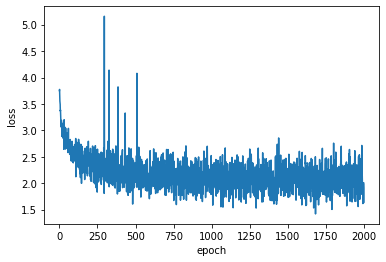

In [33]:
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [34]:
#generator function for generating text
def generate_sample(rnn, seed_phrase=' hello', max_length=20, temperature=1.0):
    hidden = rnn.init_hidden()

    batch_ix = text_to_matrix(seed_phrase, token_to_idx)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    tensor = torch.LongTensor(batch_ix.argmax(dim=1))
    for p in range(len(seed_phrase) - 1):
        _, hidden = rnn(tensor[p], hidden)
    inp = tensor[-1]

    predicted = seed_phrase

    for p in range(max_length - len(seed_phrase)):
        output, hidden = rnn(inp, hidden)
        
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        predicted_char = idx_to_token[int(top_i)]
        predicted += predicted_char
        inp = Variable(torch.tensor([token_to_idx[predicted_char]]))

    return predicted


In [41]:
rnn_copy = rnn
print(generate_sample(rnn_copy, max_length=500, seed_phrase='loving', temperature=0.2))


loving the the so the the the the to the the the the the the the and the the the the the the the the the the the the sto the the the the the the the the the the the the the and the the the the the so the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the to the the the the the the the the the the the and the the the the the the the the sto the the the the and the the the the the and the the the the so the th


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [36]:
# Your beautiful code here

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [37]:
# Text generation with different temperature values here

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [38]:
# Saving and loading code here

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)